In [3]:
#Path Settings + Helper Functions
# الفكرة: نحدد مسار مجلد التقسيمات (train/val/test)، ونجهّز دوال بسيطة نستخدمها لاحقاً.

from pathlib import Path
import hashlib
import pandas as pd

# هذا المسار فيه المجلدات الثلاثة: train / val / test
ROOT = Path("dataset_split") 

# امتدادات الصور اللي بنعتبرها
EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp'}

def is_img(p: Path) -> bool:
    "Make sure the file is an image with a known extension "
    return p.is_file() and p.suffix.lower() in EXTS

def sha256(p: Path, buf_size: int = 1<<20) -> str:
    "We calculate the SHA256 fingerprint of the file to detect 100% identical duplicates"
    h = hashlib.sha256()
    with p.open('rb') as f:
        while True:
            chunk = f.read(buf_size)
            if not chunk: break
            h.update(chunk)
    return h.hexdigest()

Quick check that the divisions are there and that we have categories

In [5]:
# الهدف: نطبع نبذة سريعة قبل ما نبدأ تنظيف أو حذف

splits_found = [sp for sp in ("train", "val", "test") if (ROOT/sp).exists()]
print(" Existing divisions:", splits_found)

classes = set()
for sp in splits_found:
    d = ROOT/sp
    classes |= {c.name for c in d.iterdir() if c.is_dir()}
print("Number of categories:", len(classes))
print("Top 10 categories:", sorted(classes)[:10])

 Existing divisions: ['train', 'val', 'test']
Number of categories: 32
Top 10 categories: ['ain', 'al', 'aleff', 'bb', 'dal', 'dha', 'dhad', 'fa', 'gaaf', 'ghain']


Detect duplicates without actual deletion (Dry Run)

In [7]:
# الهدف: نعرف وش الملفات المكررة "بالضبط" داخل كل فئة عبر (train/val/test) قبل الحذف.

DRY_RUN = True  # خليه True الآن. بعد ما نتاكد نغيره  False في الخلية التالية.

def find_dups(root: Path):
    removed_candidates = []
    classes = set()
    for sp in ("train","val","test"):
        d = root/sp
        if d.exists():
            classes |= {c.name for c in d.iterdir() if c.is_dir()}

    for cls in sorted(classes):
        seen = {}
        for sp in ("train","val","test"):  # نحافظ على train أول، بعدين val، بعدين test
            d = root/sp/cls
            if not d.exists(): continue
            for p in d.rglob("*"):
                if not is_img(p): continue
                h = sha256(p)
                if h in seen:
                    removed_candidates.append(p)
                else:
                    seen[h] = p
    return removed_candidates

dups = find_dups(ROOT)
print(f"Number of duplicate files (candidates for deletion): {len(dups)}")
for p in dups[:10]:
    print("example:", p)

Number of duplicate files (candidates for deletion): 5627
example: dataset_split/train/ain/AIN (933).JPG
example: dataset_split/train/ain/AIN (909).JPG
example: dataset_split/train/ain/AIN (1026).JPG
example: dataset_split/train/ain/AIN (987).JPG
example: dataset_split/train/ain/AIN (968).JPG
example: dataset_split/train/ain/AIN (1010).JPG
example: dataset_split/train/ain/AIN (895).JPG
example: dataset_split/train/ain/AIN (944).JPG
example: dataset_split/train/ain/AIN (905).JPG
example: dataset_split/train/ain/AIN (840).JPG


يعني فيه ٥٦٢٧ صورة مكررة بالضبط^^^

In [8]:
#Actually delete duplicates

DRY_RUN = False 

def dedupe(root: Path, dry_run: bool = True):
    removed = []
    classes = set()
    for sp in ("train","val","test"):
        d = root/sp
        if d.exists():
            classes |= {c.name for c in d.iterdir() if c.is_dir()}

    for cls in sorted(classes):
        seen = {}
        for sp in ("train","val","test"):
            d = root/sp/cls
            if not d.exists(): continue
            for p in d.rglob("*"):
                if not is_img(p): continue
                h = sha256(p)
                if h in seen:
                    removed.append(p)
                    if not dry_run:
                        try:
                            p.unlink()
                        except Exception as e:
                            print(f"Delete failed {p}: {e}")
                else:
                    seen[h] = p
    return removed

removed = dedupe(ROOT, dry_run=DRY_RUN)
print(f"{'Deleted' if not DRY_RUN else 'Candidate for deletion'}: {len(removed)} file")

Deleted: 5627 file


In [9]:
# إعادة كشف للتأكد ما بقى مكررات
dups_after = find_dups(ROOT)
print(" Duplicate after deletion :", len(dups_after))

 Duplicate after deletion : 0


Distribution statistics for each division and class + save CSV

In [10]:
# الهدف: نشوف هل فيه تفاوت بين الفئات (عدم توازن)، ونحفظ جدول رسمي نرجع له وقت التدريب.

def split_distribution(root: Path) -> pd.DataFrame:
    rows=[]
    for sp in ("train","val","test"):
        d = root/sp
        if not d.exists(): continue
        for cls in sorted(c.name for c in d.iterdir() if c.is_dir()):
            n = sum(1 for p in (d/cls).rglob("*") if is_img(p))
            rows.append({"split": sp, "class": cls, "count": n})
    return pd.DataFrame(rows).sort_values(["split","class"]).reset_index(drop=True)

dist = split_distribution(ROOT)
display(dist.head(20))

# ملخص سريع

summary = dist.groupby("split")["count"].agg(['sum','mean','std','min','max'])
cv = dist.groupby("split")["count"].apply(lambda s: (s.std(ddof=1)/s.mean()) if s.mean() else 0).rename("CV")

print("summary:")
display(summary)
print("\n⚖️ Coefficient of variation (CV) for each split: :\n", cv)

# نحفظ الإحصائية كـ CSV

dist.to_csv("class_distribution_by_split.csv", index=False)
print(" Saved  class_distribution_by_split.csv")

,split,class,count
0,test,ain,191
1,test,al,135
2,test,aleff,136
3,test,bb,161
4,test,dal,139
5,test,dha,153
6,test,dhad,149
7,test,fa,178
8,test,gaaf,151
9,test,ghain,182


summary:


,sum,mean,std,min,max
split,,,,,
test,4828,150.87500,17.392527,119,191
train,38791,1212.21875,134.046630,943,1540
val,4803,150.09375,17.439960,117,192



⚖️ Coefficient of variation (CV) for each split: :
 split
test     0.115278
train    0.110580
val      0.116194
Name: CV, dtype: float64
 Saved  class_distribution_by_split.csv


A graph showing the distribution of each division.

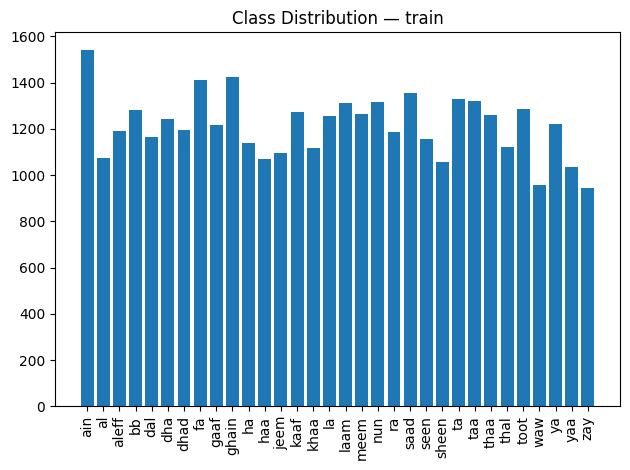

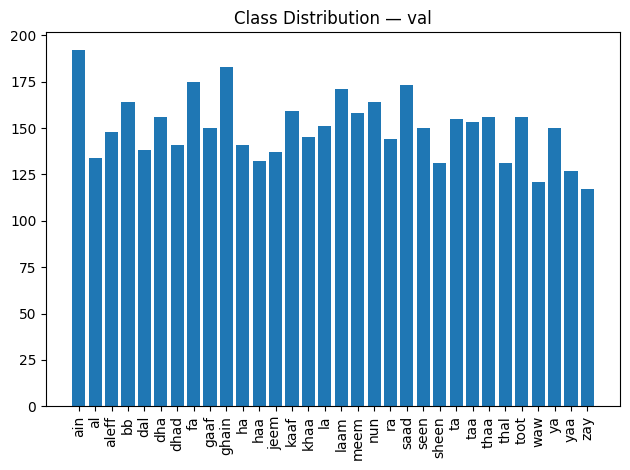

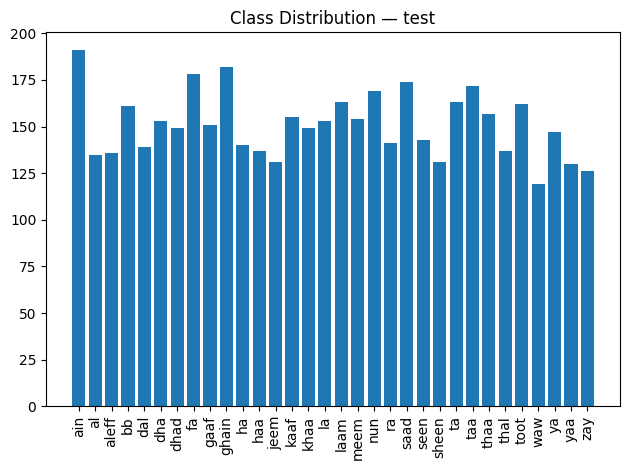

In [11]:
# الهدف: نشوف التفاوت بالعين — لو فيه فئات قليلة جدًا واضحة.

import matplotlib.pyplot as plt

for sp in ("train","val","test"):
    dsp = dist[dist["split"]==sp]
    if dsp.empty: 
        print(f"مافي بيانات لـ {sp}")
        continue
    plt.figure()
    plt.bar(dsp["class"], dsp["count"])
    plt.xticks(rotation=90)
    plt.title(f"Class Distribution — {sp}")
    plt.tight_layout()
    plt.show()

Detect corrupted/too small images

In [ ]:
# الهدف: نتأكد ما عندنا صور خربانة أو أبعادها صغيرة جدًا تضر التدريب.

from PIL import Image

def is_bad_image(p: Path):
    try:
        with Image.open(p) as im:
            im.verify()  # يكشف ملفات تالفة
        with Image.open(p) as im:
            if im.width < 20 or im.height < 20:  # صغيرة جدًا
                return True
        return False
    except Exception:
        return True

bad = []
for sp in ("train","val","test"):
    d = ROOT/sp
    if not d.exists(): continue
    for p in d.rglob("*"):
        if is_img(p) and is_bad_image(p):
            bad.append(p)

print("Number of damaged/invalid images:", len(bad))
for p in bad[:10]:
    print("example:", p)


Number of damaged/invalid images: 0


Augmentation definition (applies training time) + Important note for Sign Language

In [13]:
# الهدف: نحضّر باراميترات Augmentation وننتبه لموضوع الـflip لو يغيّر معنى الإشارة.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH = 32

# ملاحظة مهمة: لو قلب الصورة أفقيًا يغيّر معنى الإشارة (يمين/يسار)، عطّلي horizontal_flip
ALLOW_FLIP = False  # غيّريها True فقط إذا متأكدة ما يغيّر المعنى عندكم

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.10,
    brightness_range=(0.9, 1.1),
    horizontal_flip=ALLOW_FLIP
)

val_test_gen = ImageDataGenerator(rescale=1./255)

# مجرد تعريف (ممكن تستخدمينه في Notebook التدريب)
print("Augmentation is ready. Reminder: horizontal_flip=", ALLOW_FLIP)

Augmentation is ready. Reminder: horizontal_flip= False
